2427 2427
[  0.00000000e+00   4.12201154e-02   8.24402308e-02 ...,   9.99175598e+01
   9.99587799e+01   1.00000000e+02] [  9.18988441e-11 +0.00000000e+00j  -1.37156548e+00 -1.15822558e+00j
  -3.41869951e+00 +1.79393388e+01j ...,   3.49036652e-01 +1.48197407e-03j
   3.48889374e-01 -3.94018084e-03j   3.49154827e-01 +0.00000000e+00j]


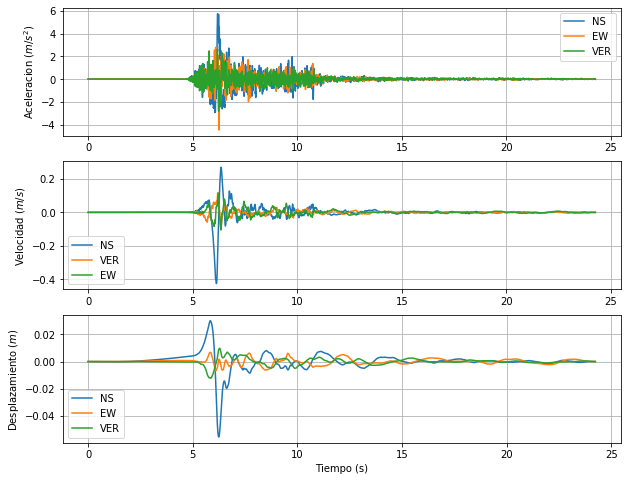

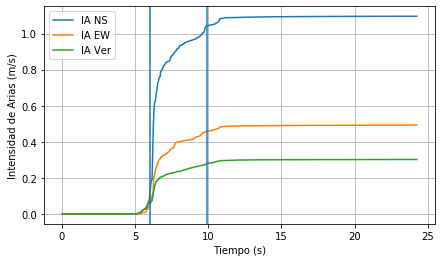

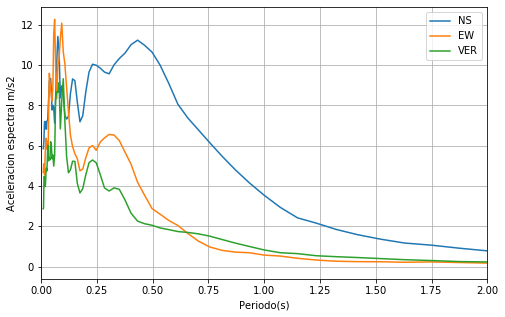

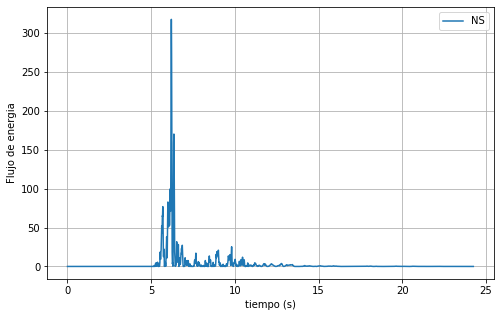

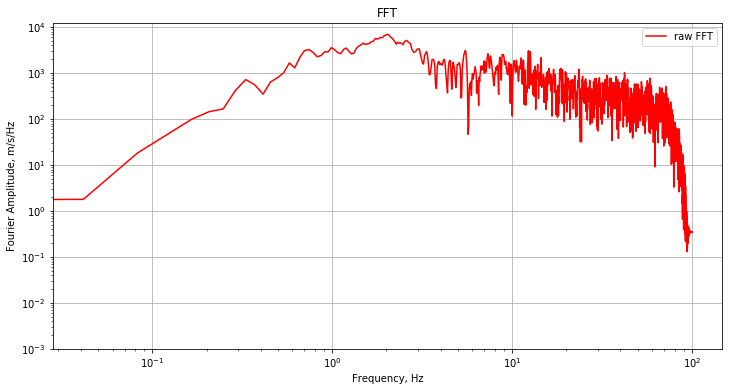

In [3]:
import numpy as np
from obspy.core import Trace,Stream,UTCDateTime,Stats
import matplotlib.pyplot as plt
import pyrotd
from numpy.fft import rfft, rfftfreq
import obspy.signal.util

import obspy
from obspy.signal.detrend import polynomial,spline
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing #FFT suavizada con el método de konno_ohmachi

import scipy
from scipy import integrate
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift

class MovimientoFuerte():
    
    def __init__(self,file):
        '''Inicializa con valores del file .anc'''
        self.file = file
        archivo = open(self.file,"r")
        linea = archivo.readlines()
        self.sismo = linea[1]
        self.lat_evento = float(linea[2][28:35])
        self.long_evento = float(linea[3][28:35])
        self.profundidad_evento = float(linea[4][28:33])
        self.codigo_estacion = linea[5][23:28]
        self.estacion = linea[6]
        self.lat_estacion = float(linea[7][32:45])
        self.long_estacion = float(linea[8][34:45])
        self.dist_epicentral = float(linea[9][22:28])
        self.dist_hipocentral = float(linea[10][23:29])
        self.muestreo = float(linea[11][34:41])
        self.numero_datos = int(linea[12][17:21])
        self.duracion = float(linea[13][21:41])
        
        component_1 = linea[19][0:15].split()[0]
        component_2 = linea[19][20:36].split()[0]
        component_3 = linea[19][40:56].split()[0]
        components = {}
        
        if component_1 == 'NS':
            components['NS']=0
        else:
            if component_1 =='EW':
                components['EW']=0      
            if component_1 == 'VER':
                components['VER']=0
        if component_2 == 'NS':
            components['NS']=1
        else:
            if component_2 =='EW':
                components['EW']=1
            if component_2 == 'VER':
                components['VER']=1
        if component_3 == 'NS':
            components['NS']=2
        else:
            if component_3 =='EW':
                components['EW']=2
            if component_3 == 'VER':
                components['VER']=2

        self.EW_o = np.array([])
        self.VER_o = np.array([])
        self.NS_o = np.array([])
        
        for line in linea[20:len(linea)]:
            
            self.NS_line = float(line.split()[components['NS']])/100
            self.VER_line = float(line.split()[components['VER']])/100
            self.EW_line = float(line.split()[components['EW']])/100
            
            self.EW_o = np.append(self.EW_o, self.EW_line)
            self.VER_o = np.append(self.VER_o, self.VER_line)
            self.NS_o = np.append(self.NS_o, self.NS_line)
            
        #self.VER = scipy.signal.detrend(self.VER_o, axis=-1, type='linear', bp=0)
        #self.NS = scipy.signal.detrend(self.NS_o, axis=-1, type='linear', bp=0)
        #self.EW = scipy.signal.detrend(self.EW_o, axis=-1, type='linear', bp=0)

        #self.VER = polynomial(self.VER_o, order=2)
        #self.NS = polynomial(self.NS_o, order=2)
        #self.EW = polynomial(self.EW_o, order=2)
        
        self.VER = spline(self.VER_o, order=2, dspline=1000)  
        self.NS = spline(self.NS_o, order=2, dspline=1000)
        self.EW = spline(self.EW_o, order=2, dspline=1000)
        
        self.tiempo = np.arange(0,self.duracion,self.muestreo)
        self.tiempoV = self.tiempo[0:len(self.tiempo)-1]
        self.tiempoD = self.tiempoV[0:len(self.tiempoV)-1]

        self.vel_VER = integrate.cumtrapz(self.VER, self.tiempo, self.muestreo, 0)
        self.vel_NS = integrate.cumtrapz(self.NS, self.tiempo, self.muestreo, 0)
        self.vel_EW = integrate.cumtrapz(self.EW, self.tiempo, self.muestreo, 0)
                                    
        self.desp_VER = integrate.cumtrapz(self.vel_VER, self.tiempoV, self.muestreo, 0)
        self.desp_NS = integrate.cumtrapz(self.vel_NS, self.tiempoV, self.muestreo, 0)
        self.desp_EW = integrate.cumtrapz(self.vel_EW, self.tiempoV, self.muestreo, 0)
        
        '''Informacion colores plot'''
        self.infplot = {'NS':{'Color':'green','label':'NS'},
                        'EW':{'Color':'orange','label':'EW'},
                         'VER':{'Color':'blue','label':'VER'}}
      
    def grafica_acel(self):      
       
        plt.figure(figsize=(10,8))
        plt.title('Aceleracion')

        plt.subplot(3,1,1)
        plt.plot(self.tiempo,self.NS,label=self.infplot['NS']['label'])
        plt.plot(self.tiempo,self.EW,label=self.infplot['EW']['label'])
        plt.plot(self.tiempo,self.VER,label=self.infplot['VER']['label'])
        plt.grid()
        plt.legend()
        plt.ylabel("Aceleracion ($m/s^2$)")
        plt.plot()

        plt.subplot(3,1,2)
        plt.plot(self.tiempoV,self.vel_NS,label="NS")
        plt.plot(self.tiempoV,self.vel_VER,label="VER")
        plt.plot(self.tiempoV,self.vel_EW,label="EW")
        plt.grid()
        plt.legend()
        plt.ylabel("Velocidad ($m/s$)")
        plt.plot()

        plt.subplot(3,1,3)
        plt.plot(self.tiempoD,self.desp_NS,label="NS")
        plt.plot(self.tiempoD,self.desp_EW,label="EW")
        plt.plot(self.tiempoD,self.desp_VER,label="VER")
        plt.grid()
        plt.legend()
        plt.ylabel("Desplazamiento ($m$)")
        plt.xlabel("Tiempo (s)")
        plt.plot()
        
    def val_pico(self):
        
        # Parametros maximos
        self.PGA = np.max(np.abs(self.NS))
        self.PGV = np.max(np.abs(self.vel_NS))
        self.PGD = np.max(np.abs(self.desp_NS))
        
        self.ratioAV = self.PGA / self.PGV
        self.newmark_p = (self.PGA*self.PGD)/ self.PGV**2
        
    def IA(self):
        
       
        # Funciones de integracion a(t)**2

        y_integrate_NS = self.NS**2
        y_integrate_EW = self.EW**2
        y_integrate_VER = self.VER**2
        
        factor_IA = np.pi/(2*9.8)
        
        # Se integra con la ley del trapecio
        arias_inte_NS = integrate.cumtrapz(y_integrate_NS,self.tiempo,self.muestreo,0)
        arias_inte_EW = integrate.cumtrapz(y_integrate_EW,self.tiempo,self.muestreo,0)
        arias_inte_VER = integrate.cumtrapz(y_integrate_VER,self.tiempo,self.muestreo,0)
        
        #Se determina la intensidad de Arias
        arias_NS = factor_IA * arias_inte_NS
        arias_EW = factor_IA * arias_inte_EW
        arias_VER = factor_IA * arias_inte_VER
        
        arias = np.array([arias_VER, arias_NS, arias_EW])
        
        self.IAr = np.max([arias_VER, arias_NS, arias_EW])        
        
        arias_5 = 0.05 * self.IAr
        arias_95 = 0.95 * self.IAr
        
        delta_5 = np.abs(arias_5 - arias)
        result_5 = np.where(delta_5 == np.amin(delta_5))
        self.tiempo_5arias = result_5[1] * self.muestreo
        
        delta_95 = np.abs(arias_95 - arias)
        result_95 = np.where(delta_95 == np.amin(delta_95))
        self.tiempo_95arias = result_95[1] * self.muestreo
        
        self.duracionIA = self.tiempo_95arias - self.tiempo_5arias

        plt.figure(figsize=(7,4))
        plt.plot(self.tiempoV, arias_NS,label="IA NS")
        plt.plot(self.tiempoV, arias_EW,label="IA EW")
        plt.plot(self.tiempoV, arias_VER, label="IA Ver")
        plt.axvline(self.tiempo_5arias)
        plt.axvline(self.tiempo_95arias)
        plt.grid()
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Intensidad de Arias (m/s)") 
        plt.legend()
        plt.plot()
        
    def espectro_respuestaA(self):
        
        # Parametros de entrada
        osc_damping = 0.05
        osc_freqs = np.logspace(-1, 2, 100)
        time_step = self.muestreo
        
        # Determinacion de los espectros de respuesta de aceleracion para cada componente

       
        self.osc_respsNS = pyrotd.calc_spec_accels(
                time_step, self.NS, osc_freqs, osc_damping
        )
        self.osc_respsEW = pyrotd.calc_spec_accels(
                time_step, self.EW, osc_freqs, osc_damping
        )      
        
        self.osc_respsVER = pyrotd.calc_spec_accels(
                time_step, self.VER, osc_freqs, osc_damping
        )


        # Se determinan los periodos para las graficas
        self.periodoNS =1/ self.osc_respsNS.osc_freq
        self.periodoEW =1/ self.osc_respsEW.osc_freq
        self.periodoVER =1/ self.osc_respsVER.osc_freq

        self.osc_respsNS.spec_accel        
        self.osc_respsEW.spec_accel
        self.osc_respsVER.spec_accel
        
        # Se determinan espectros de velocidades

        self.PSV_NS = self.osc_respsNS.spec_accel / self.osc_respsNS.osc_freq
        self.PSV_EW = self.osc_respsEW.spec_accel / self.osc_respsEW.osc_freq
        self.PSV_VER = self.osc_respsVER.spec_accel / self.osc_respsVER.osc_freq
        
        
        #PSD = PSV / osc_respsNS.osc_freq
        self.PSD_NS = self.PSV_NS / self.osc_respsNS.osc_freq
        self.PSD_EW = self.PSV_EW / self.osc_respsEW.osc_freq
        self.PSD_VER = self.PSV_VER / self.osc_respsVER.osc_freq
        
        plt.figure(figsize=(8,5))
        plt.plot(self.periodoNS, self.osc_respsNS.spec_accel, label="NS")
        plt.plot(self.periodoEW, self.osc_respsEW.spec_accel, label="EW")
        plt.plot(self.periodoVER, self.osc_respsVER.spec_accel, label="VER")
        plt.plot()
        plt.grid()
        plt.legend()
        plt.xlabel("Periodo(s)")
        plt.ylabel("Aceleracion espectral m/s2")
        plt.xlim(0,2)
        plt.plot()
        
    def fourier(self):
        
        delta= self.muestreo
        npts = self.numero_datos
        self.spec, freqs = rfft(self.NS), rfftfreq(npts, 0.005)
        self.DFAS = self.spec * self.duracion
        self.Pw = self.DFAS**2 /(np.pi*self.duracion)
        
        print(len(freqs),len(self.DFAS))
        print(freqs,self.DFAS)
        
        fig= plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        ax.loglog(freqs, np.abs(self.DFAS), label="raw FFT", color="red") #espectro crudo
        ax.set_ylim(0.001,np.max(self.DFAS).real*2)
        ax.set_title('FFT')
        ax.set_xlabel('Frequency, Hz')
        ax.set_ylabel('Fourier Amplitude, m/s/Hz')
        ax.grid()
        ax.legend()
        plt.show()
        
    def energy_density(self):
        
        C = 4500
        r = self.dist_hipocentral
        dens_material = 20
  
        y_integrate_VER = self.vel_VER**2
        y_integrate_NS = self.vel_NS**2
        y_integrate_EW = self.vel_EW**2
        
        integral_v2 = np.max(integrate.cumtrapz(y_integrate_VER,self.tiempoV,self.muestreo,0))
        
        self.Eo = 4*np.pi*(r*1000)**2*dens_material*C*integral_v2
        self.E = self.Eo / (4*np.pi*r**2)
        self.E_free = np.max(self.E / 4)
        self.flux_energy = dens_material*C*y_integrate_VER / 4
        self.flux_energy_max = np.max(self.flux_energy)
        
        
        plt.figure(figsize=(8,5))
        plt.plot(self.tiempoV,self.flux_energy, label="NS")
        plt.plot()
        plt.grid()
        plt.legend()
        plt.xlabel("tiempo (s)")
        plt.ylabel("Flujo de energia")
        plt.plot()
        
    def VDV(self):
        
        y_integrate_EW = self.EW**4      
        # Se integra con la ley del trapecio
        self.vdv = (np.max(integrate.cumtrapz(y_integrate_EW,self.tiempo,self.muestreo,0)))**(1/4)


X = MovimientoFuerte("20080524192044_CQUET.anc")
X.grafica_acel()
#X.val_pico()
#print(X.ratioAV)
X.IA()
X.espectro_respuestaA()
X.energy_density()
X.VDV()
#print(X.vdv)
X.fourier()





In [23]:
import os
dirlist = os.listdir(".")

print(dirlist)

['.ipynb_checkpoints', '20080524192044_CANAP.anc', '20080524192044_CANSE.anc', '20080524192044_CARBE.anc', '20080524192044_CARME.anc', '20080524192044_CBOG2.anc', '20080524192044_CBUC1.anc', '20080524192044_CCALA.anc', '20080524192044_CCUC3.anc', '20080524192044_CFILA.anc', '20080524192044_CFQNE.anc', '20080524192044_CGUAD.anc', '20080524192044_CIBA1.anc', '20080524192044_CIBA3.anc', '20080524192044_CMAN1.anc', '20080524192044_COCAN.anc', '20080524192044_CPENS.anc', '20080524192044_CPRAD.anc', '20080524192044_CQUET.anc', '20080524192044_CREAC.anc', '20080524192044_CROSA.anc', '20080524192044_CSJGU.anc', '20080524192044_CTRUJ.anc', '20080524192044_CTUN2.anc', '20080524192044_CTUN3.anc', '20080524192044_CVIL1.anc', '20080524192044_CYOPA.anc', 'ascci_mseed.ipynb']


19940606204739_CPENS.anc
19940606204739_CVHER.anc
19940606204739_ROSC.anc
19990125181918_ARMEC.anc
19990125181918_BOG.anc
19990125181918_CANDE.anc
19990125181918_CARBE.anc
19990125181918_CBETA.anc
19990125181918_CBOCA.anc
19990125181918_CBOG2.anc
19990125181918_CBUC1.anc
19990125181918_CBUEN.anc
19990125181918_CCALI.anc
19990125181918_CCAST.anc
19990125181918_CCOLO.anc
19990125181918_CCUC1.anc
19990125181918_CDAGU.anc
19990125181918_CECAL.anc
19990125181918_CFILA.anc
19990125181918_CFLAN.anc
19990125181918_CGARZ.anc


C:\Users\Leonardo Mateus\Anaconda3\lib\site-packages\ipykernel_launcher.py:297: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


19990125181918_CGUAD.anc
19990125181918_CNEIV.anc
19990125181918_CNORC.anc
19990125181918_CPENS.anc
19990125181918_CPLAT.anc
19990125181918_CPOP2.anc
19990125181918_CPOP4.anc
19990125181918_CPRAD.anc
19990125181918_CRIOS.anc
19990125181918_CSONS.anc
19990125181918_CTOCH.anc
19990125181918_CTUTU.anc
19990125181918_CVHER.anc
19990125181918_CVIL1.anc
19990125181918_FLO2.anc
19990125181918_GUA.anc
19990125181918_MAN1C.anc
19990125181918_OCA.anc
19990125181918_ROSC.anc
20080524192044_CANAP.anc
20080524192044_CANSE.anc
20080524192044_CARBE.anc
20080524192044_CARME.anc
20080524192044_CBOG2.anc
20080524192044_CBUC1.anc
20080524192044_CCALA.anc
20080524192044_CCUC3.anc
20080524192044_CFILA.anc
20080524192044_CFQNE.anc
20080524192044_CGUAD.anc
20080524192044_CIBA1.anc
20080524192044_CIBA3.anc
20080524192044_CMAN1.anc
20080524192044_COCAN.anc
20080524192044_CPENS.anc
20080524192044_CPRAD.anc
20080524192044_CQUET.anc
20080524192044_CREAC.anc
20080524192044_CROSA.anc
20080524192044_CSJGU.anc
200805

C:\Users\Leonardo Mateus\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[]

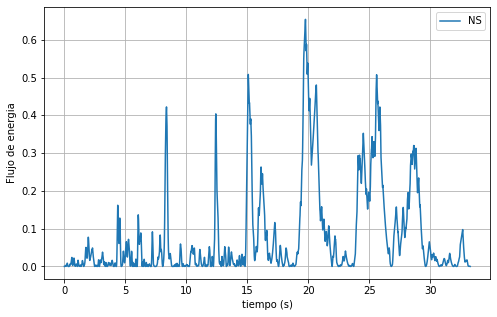

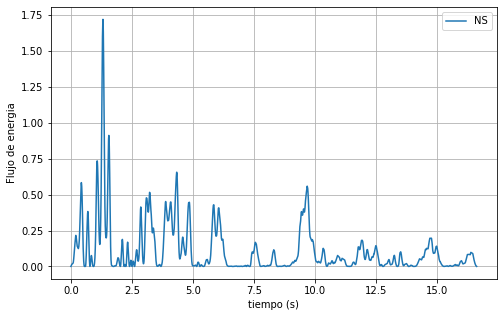

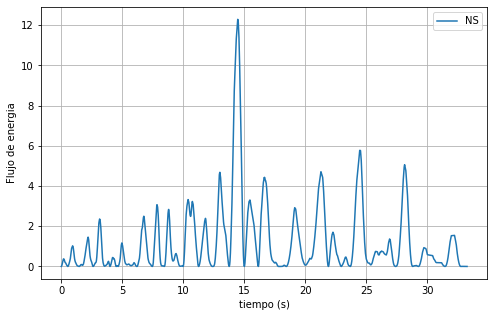

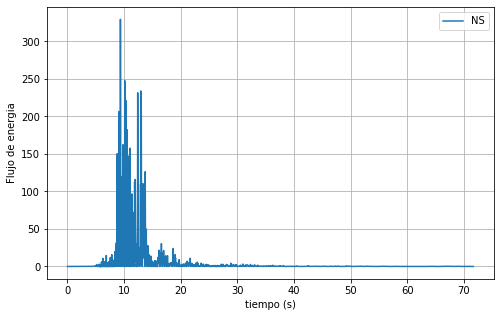

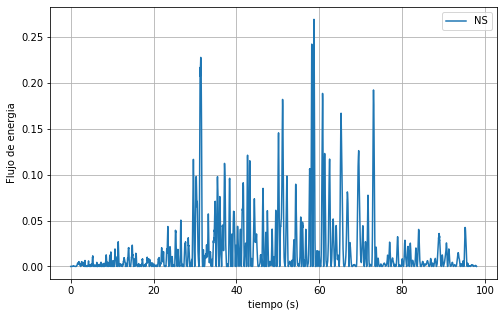

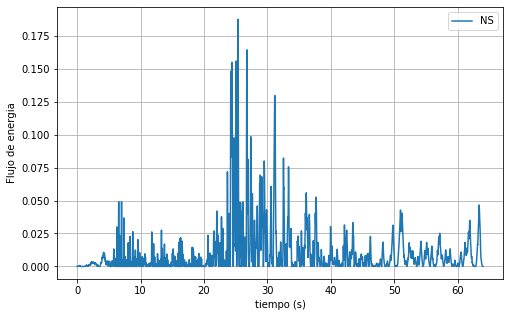

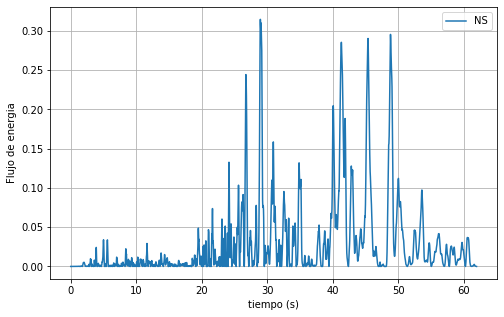

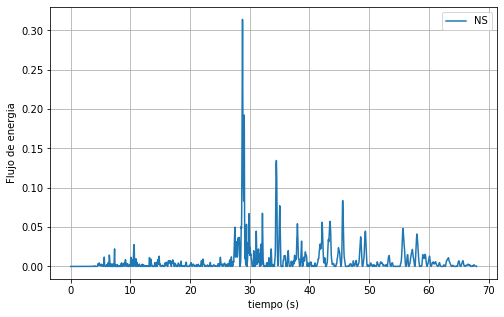

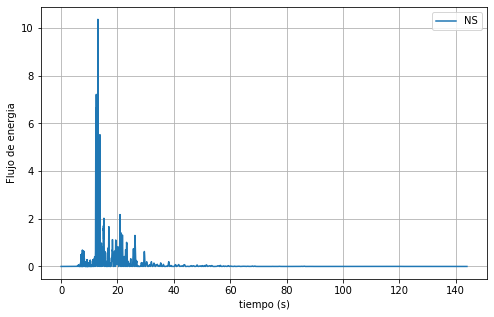

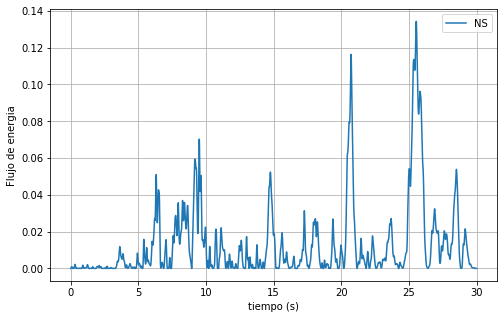

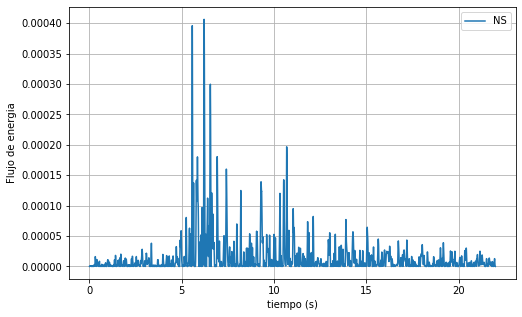

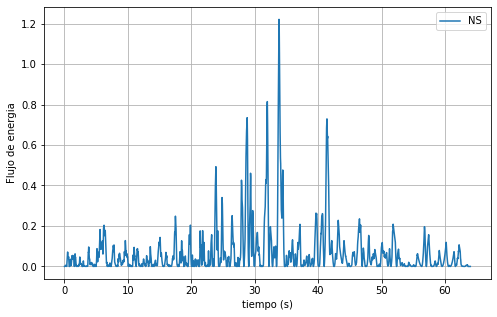

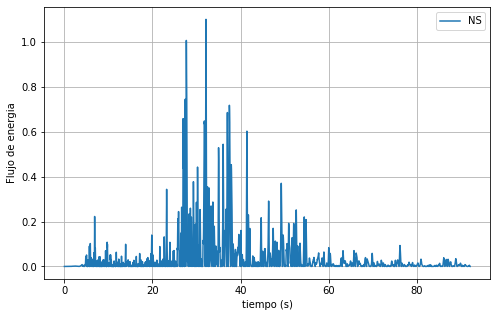

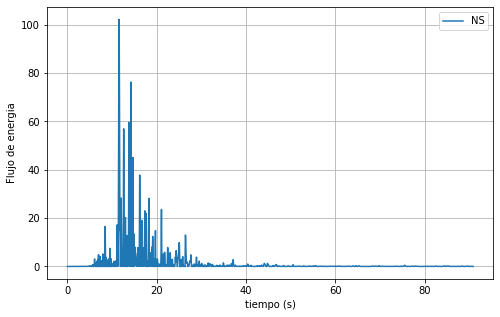

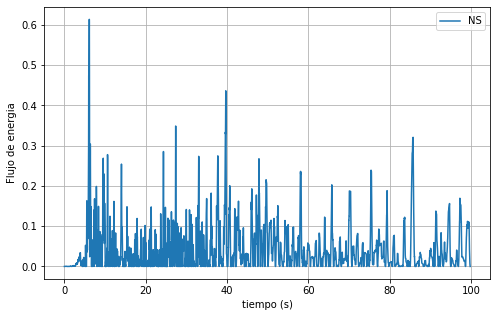

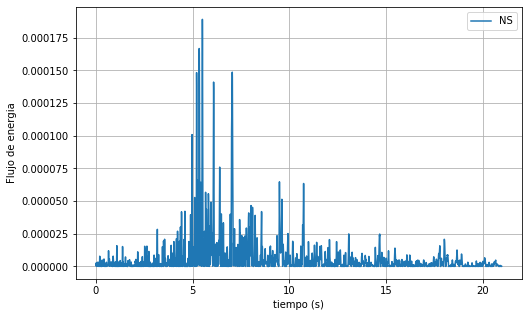

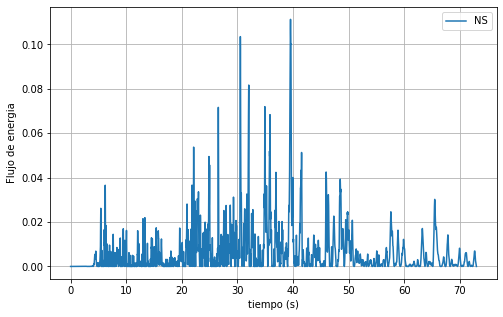

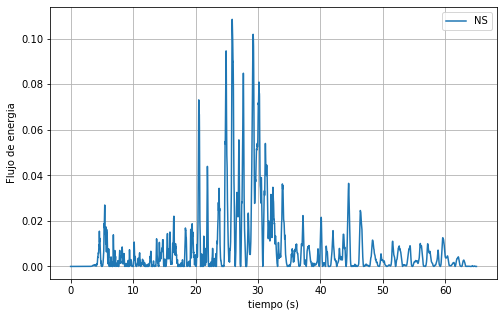

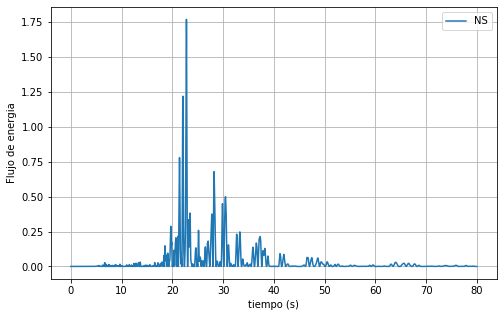

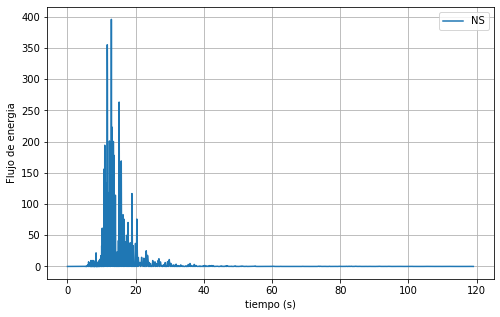

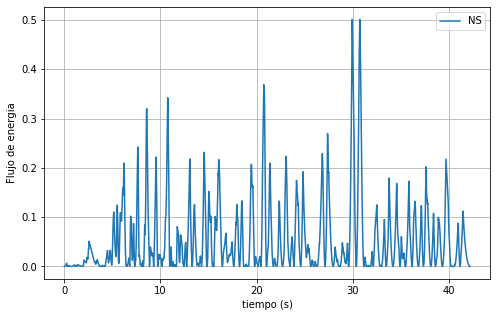

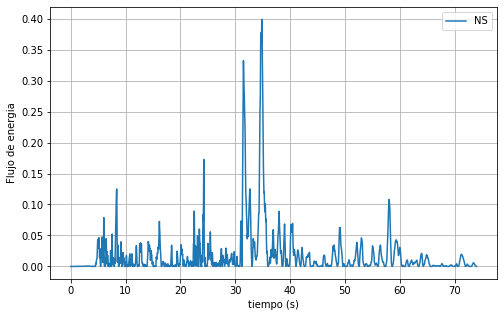

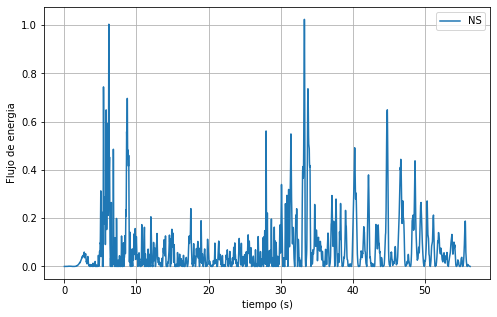

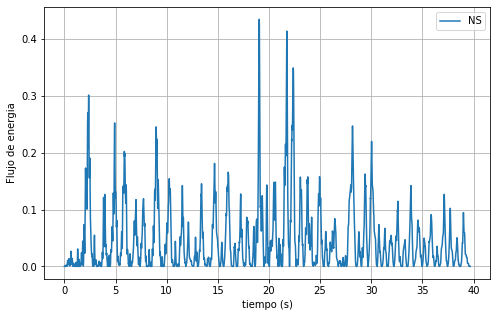

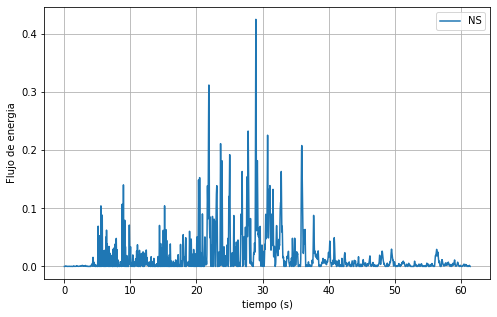

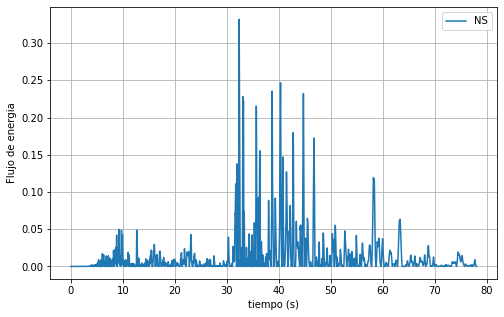

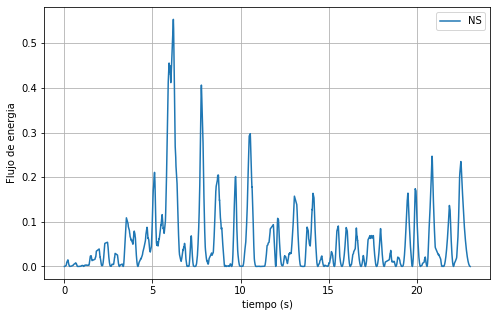

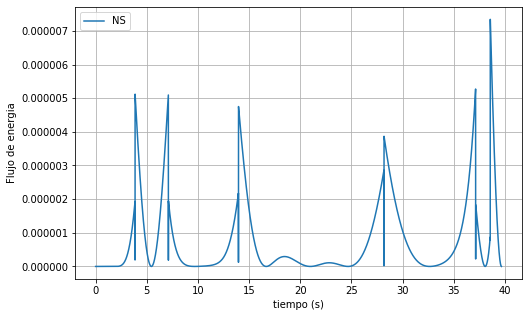

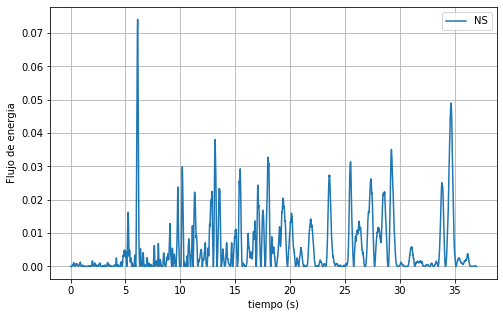

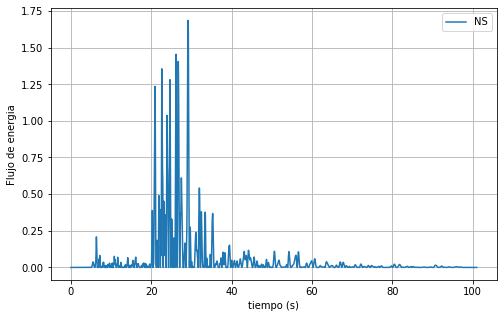

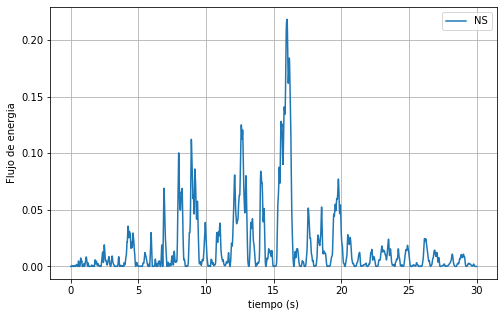

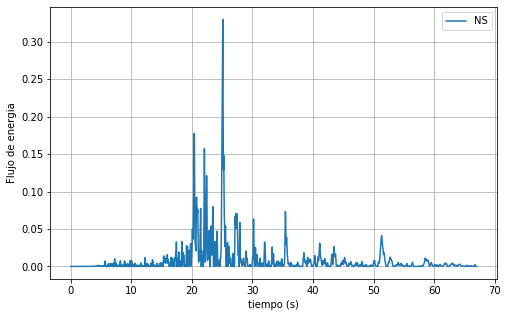

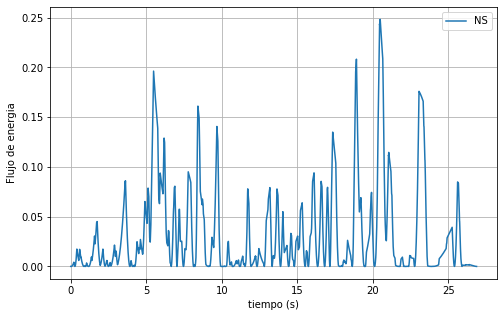

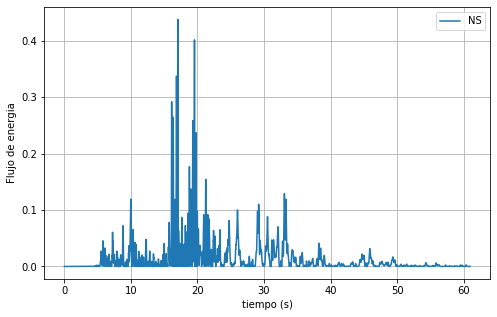

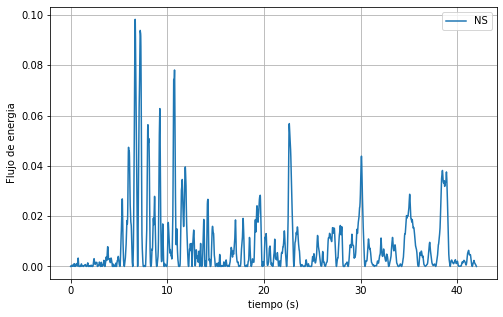

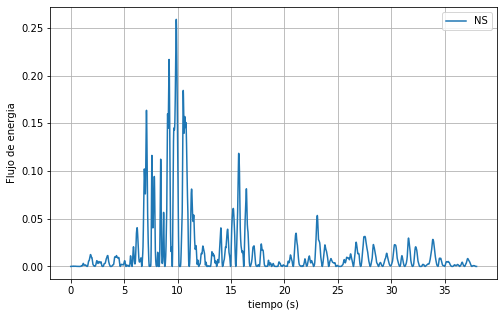

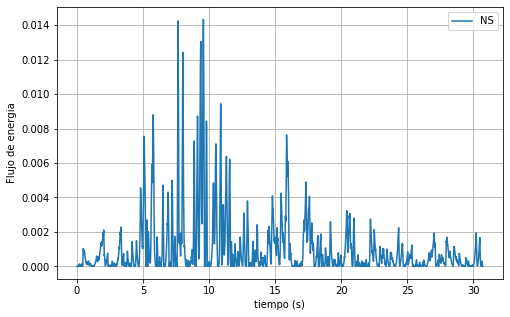

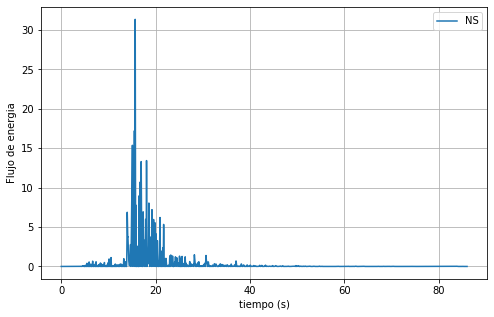

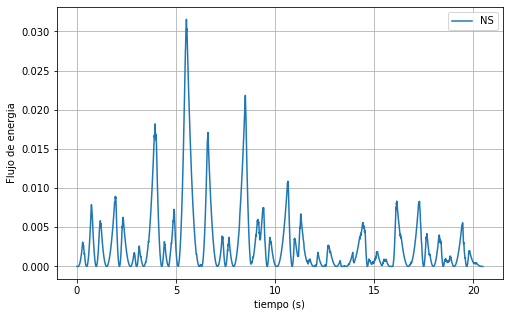

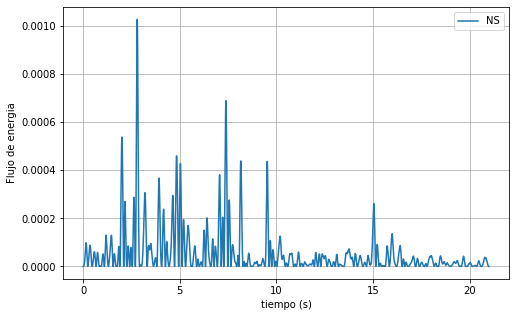

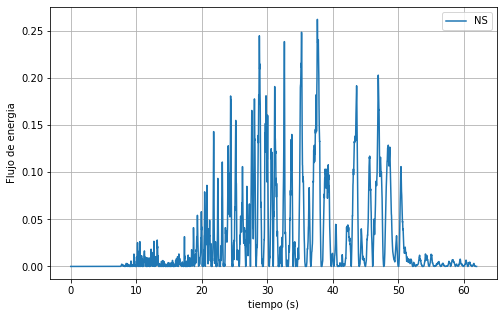

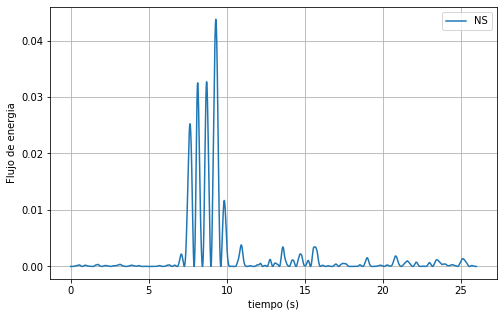

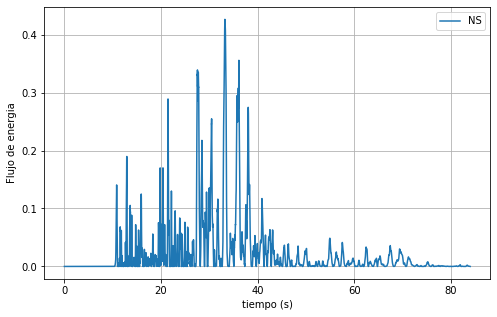

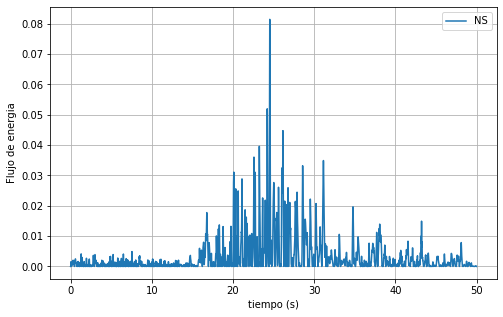

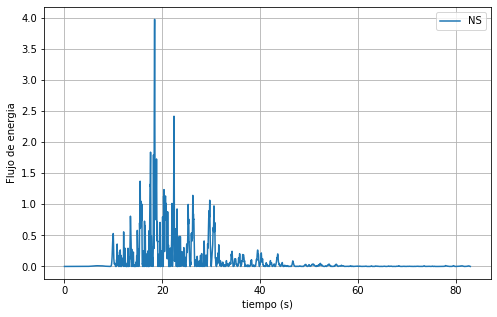

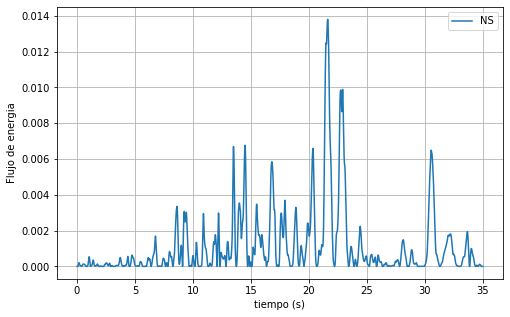

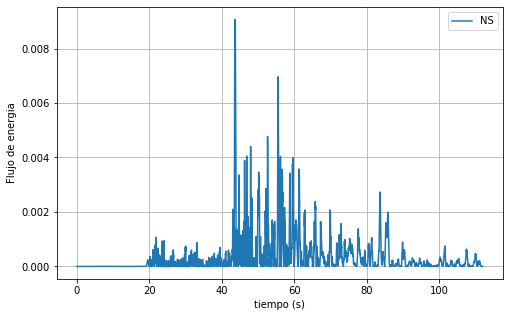

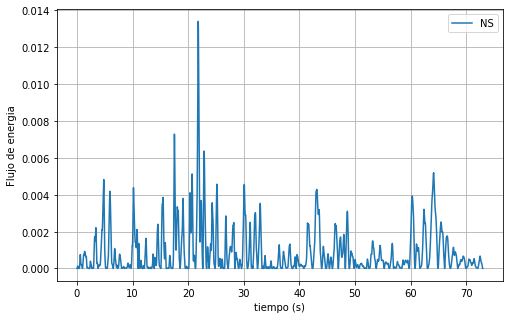

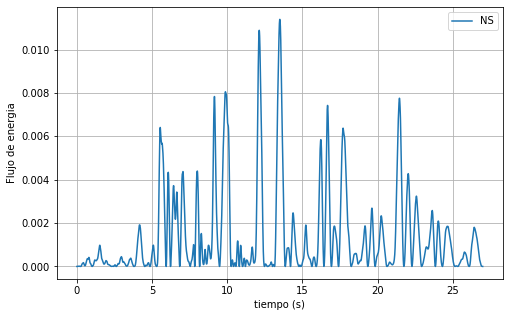

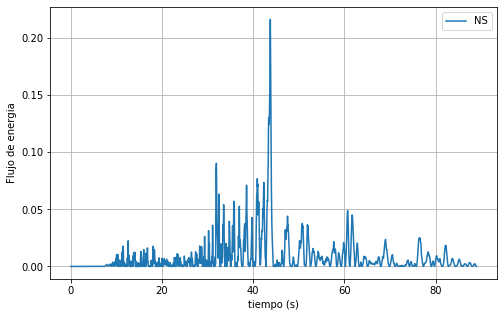

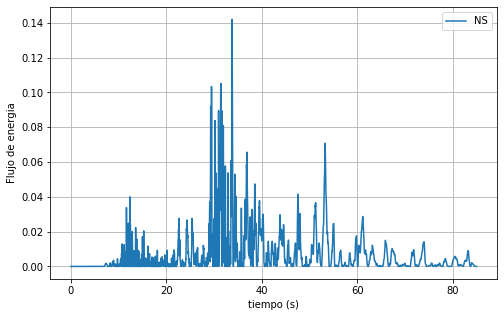

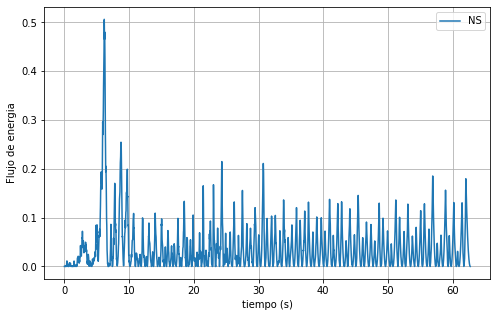

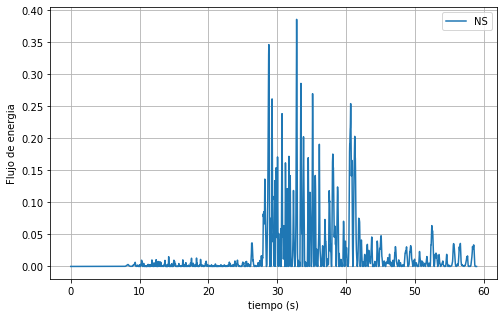

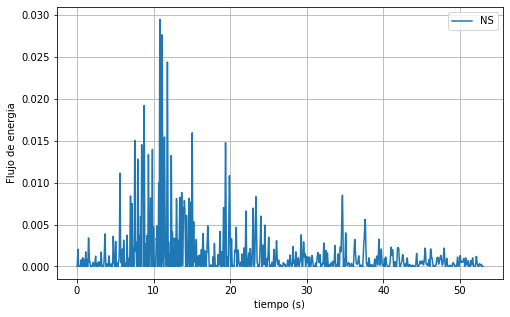

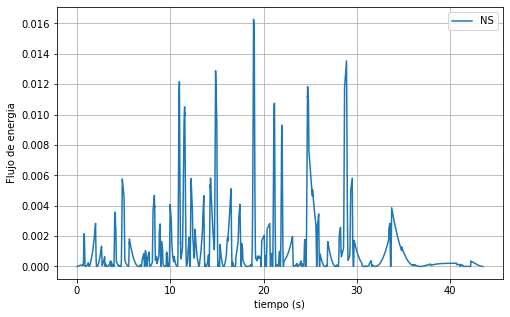

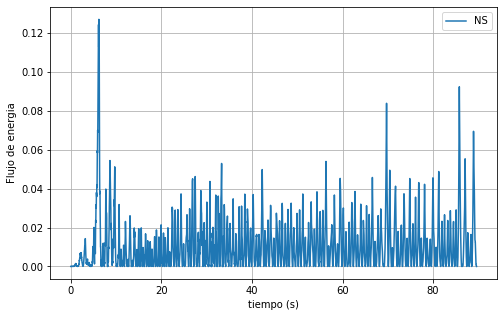

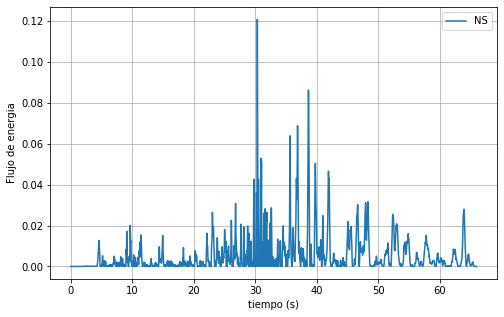

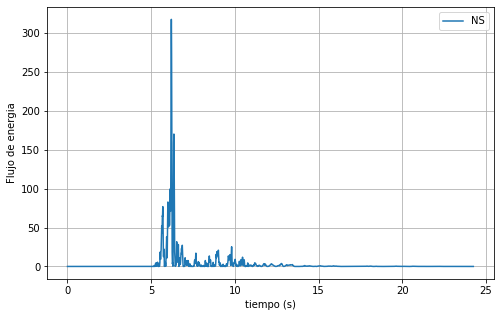

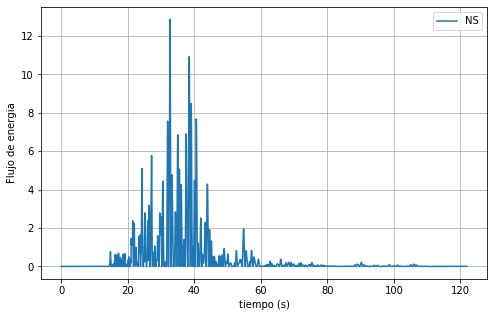

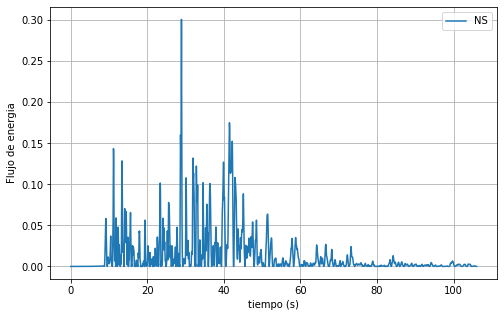

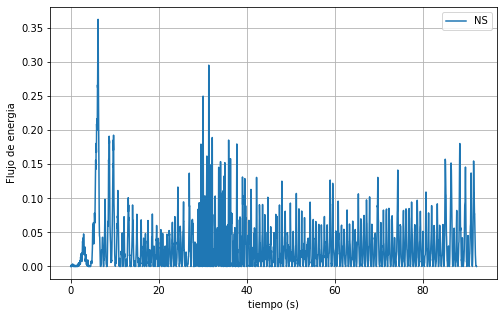

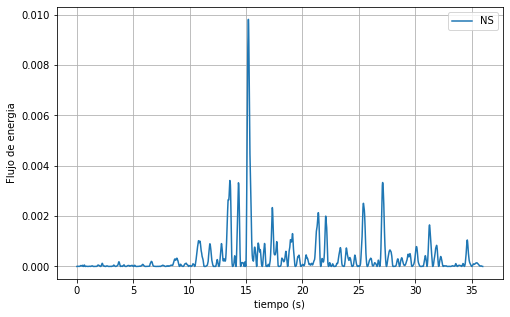

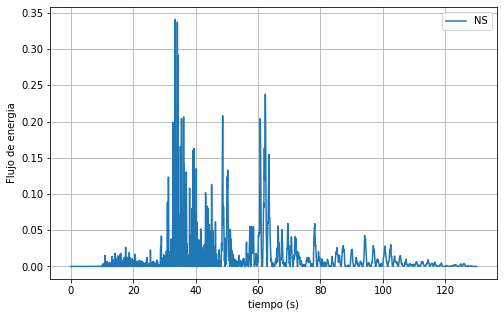

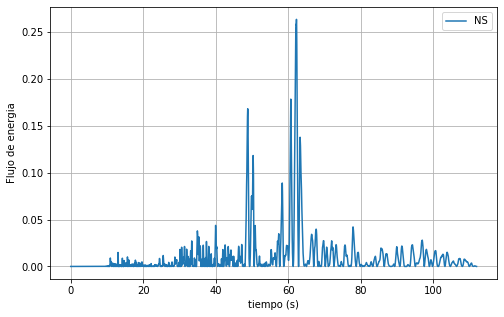

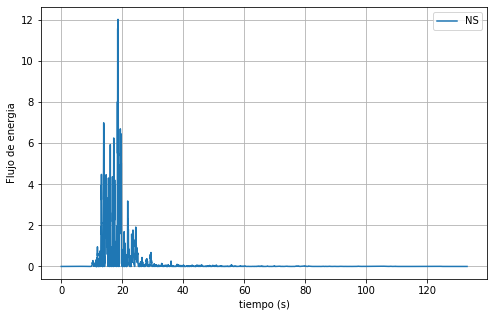

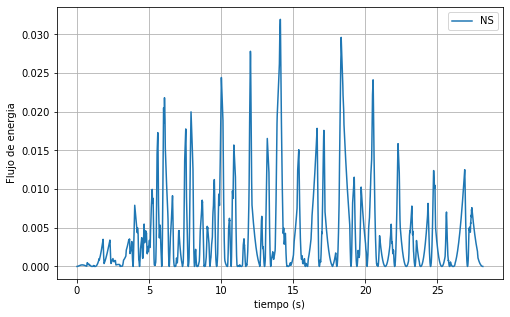

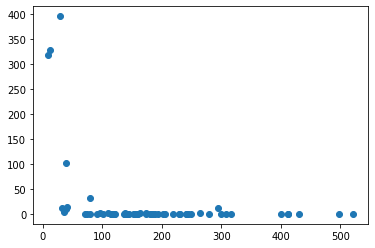

In [7]:
import glob
dirlist = glob.glob('*.anc')

parametro = []
distancia = []

for file in dirlist[1:len(dirlist)]:
    try:
        print(file)
        estacion = MovimientoFuerte(file)
        estacion.energy_density()
        parametro.append(estacion.flux_energy_max)
        distancia.append(estacion.dist_epicentral)
        #print(estacion.dist_epicentral,estacion.PGV)
    except:
        print('Error')

plt.figure()
plt.plot(distancia,parametro,'o')
#plt.xlim(0,15)
#plt.ylim(0,0.6)
plt.plot()


In [6]:
import glob
#dirlist = glob.glob('C:\Users\Leonardo Mateus\Documents\Tesis\19990125181918_anc\subdirectorio'+'*.anc')

path = r'C:\Users\Leonardo Mateus\Documents\Tesis\19990125181918_anc\subdirectorio' 


dirlist = glob.glob('*.anc')
print(dirlist)

#print(path)

parametro = []
distancia = []

for file in dirlist:
    print(file)
    estacion = MovimientoFuerte(file)
    estacion.energy_density()
    parametro.append(estacion.flux_energy_max)
    distancia.append(estacion.dist_epicentral)
    #print(estacion.dist_epicentral,estacion.PGV)

plt.figure()
plt.plot(distancia,parametro,'o')
plt.xlim(100,450)
plt.ylim(0,0.6)
plt.plot()


['19940606204739_BOG.anc', '19940606204739_CPENS.anc', '19940606204739_CVHER.anc', '19940606204739_ROSC.anc', '19990125181918_ARMEC.anc', '19990125181918_BOG.anc', '19990125181918_CANDE.anc', '19990125181918_CARBE.anc', '19990125181918_CBETA.anc', '19990125181918_CBOCA.anc', '19990125181918_CBOG2.anc', '19990125181918_CBUC1.anc', '19990125181918_CBUEN.anc', '19990125181918_CCALI.anc', '19990125181918_CCAST.anc', '19990125181918_CCOLO.anc', '19990125181918_CCUC1.anc', '19990125181918_CDAGU.anc', '19990125181918_CECAL.anc', '19990125181918_CFILA.anc', '19990125181918_CFLAN.anc', '19990125181918_CGARZ.anc', '19990125181918_CGUAD.anc', '19990125181918_CNEIV.anc', '19990125181918_CNORC.anc', '19990125181918_CPENS.anc', '19990125181918_CPLAT.anc', '19990125181918_CPOP2.anc', '19990125181918_CPOP4.anc', '19990125181918_CPRAD.anc', '19990125181918_CRIOS.anc', '19990125181918_CSONS.anc', '19990125181918_CTOCH.anc', '19990125181918_CTUTU.anc', '19990125181918_CVHER.anc', '19990125181918_CVIL1.an

ValueError: If given, length of x along axis must be the same as y.

In [19]:
ro = 100
c = 10
tan_phi = np.tan(np.pi/6)

E_interna = (c*ro)/(2*tan_phi)*np.e**(np.pi/3-1)

print(E_interna)

907.87962112
